In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/BRATS_Training.zip" -d "/content/sample_data/Dataset"  

Archive:  /content/drive/MyDrive/BRATS_Training.zip
   creating: /content/sample_data/Dataset/BRATS-2/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/
  inflating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/License_CC_BY_NC_SA_3.0.txt  
  inflating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.684.mha  
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_T1/
   creating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_T1c/
  inflating: /content/sample_data/Dataset/BRATS-2/Image_Data/HG/0001/VSD.Brain.XX.O.MR_T1c/License_CC_BY_NC_SA_3.0.txt  
  inflating: /content/sample_data/Dataset/BRATS-2/Im

In [3]:

!pip install nibabel pydicom medpy
!pip install nipype
!pip install patchify
# !pip install imgaug
!pip install imgaug 0.2.7
!pip install SimpleITK

     |████████████████████████████████| 1.9MB 17.2MB/s 
     |████████████████████████████████| 153kB 43.5MB/s 
     |████████████████████████████████| 47.4MB 61kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753432 sha256=46575626c1f9f7aa7ff80906c7c059cd20864e3c70c53af8637cee357ad2ed66
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy
     |████████████████████████████████| 3.2MB 16.3MB/s 
     |████████████████████████████████| 133kB 58.1MB/s 
     |████████████████████████████████| 5.1MB 52.8MB/s 
     |████████████████████████████████| 430kB 57.1MB/s 
     |████████████████████████████████| 235kB 61.7MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 12.4MB 213kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: s

In [4]:
import numpy as np 
from PIL import Image
from os import listdir
from os.path import isfile, join
from medpy.io import load, save
from patchify import patchify, unpatchify
import SimpleITK as sitk
from PIL import Image as im 
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

In [5]:
NUMBER_OF_0_LALBEL = 150000
#change MODE to run different cascade model 
MODE = 3 # 1 for input cascade  / 2 for local cascade / 3 for output cascade
if MODE == 1 :
  IMG_HEIGHT = 65
  IMG_WIDTH = 65
  CENTER = 32
if MODE == 2 :
  IMG_HEIGHT = 56
  IMG_WIDTH = 56
  CENTER = 28
if MODE == 3 :
  IMG_HEIGHT = 53
  IMG_WIDTH = 53
  CENTER = 26

In [6]:

def read_image(path = "/content/sample_data/Dataset/BRATS-2/Image_Data/HG"):
  all_samples_folders = [f for f in listdir(path)]
  all_sample_images = []
  s = 0
  for sample_folder in all_samples_folders:
    if s == 20:
      break
    s+=1
    sample_images = [0,0,0,0,0]
    folder_names = [f for f in listdir(path+"/"+sample_folder)]
    file_names = [f for fn in folder_names for f in listdir(path+"/"+sample_folder+"/"+fn) if ".mha" in f]
    for fn in folder_names:
      file_names = [f for f in listdir(path+"/"+sample_folder+"/"+fn) if ".mha" in f]
     
      image_data , _ = load(path+"/"+sample_folder+"/"+fn+"/"+file_names[0])
      if "T1c" in file_names[0]:
        sample_images[2] = image_data
      elif "T2" in file_names[0]:
        sample_images[1] = image_data
      elif "Flair" in file_names[0]:
        sample_images[3] = image_data
      elif "T1" in file_names[0]:
        sample_images[0] = image_data
      else:
        sample_images[4] = image_data

    
    all_sample_images.append(sample_images)

  print("number of all samples: ", len(all_sample_images))
  print("number of each sample imags: ", len(all_sample_images[0]))
  print("image shape: ", all_sample_images[0][0].shape)

  # plt.figure(figsize=(15, 12))
  # for i in range(5):
  #   plt.subplot(1,  5, i+1)
  #   plt.imshow(all_sample_images[0][i][:,:,100])

  return all_sample_images[:17],all_sample_images[17:] 

def merge_different_modality(images):
  
  all_new_sample = []
  no_tumor = 0
  for sample in images:
    new_sample = []
    for z in range(sample[0].shape[-1]):
      # un slide hayi ke tumor tush hast ro negah darim
      if np.sum(sample[4][:,:,z]) != 0:
        new_img = np.dstack((sample[0][:,:,z],sample[1][:,:,z],sample[2][:,:,z],sample[3][:,:,z],sample[4][:,:,z]))
        new_sample.append(np.array(new_img))
      else:
        no_tumor+=1
    all_new_sample.append(new_sample)

  print("no tumor: ", no_tumor)
  print("number of all samples: ",len(all_new_sample))
  print("number of each sample imags: ",len(all_new_sample[0]))
  print("image shape here: ",all_new_sample[0][0].shape)

 
  return all_new_sample
    
      

def creat_patch(images, patch_size = 33, center = 16):
  l = (patch_size - 1) / 2
  patch_sample = []
  X_train = []
  y_train = []
  l = [0,0,0,0,0]
  for sample in images:
    patch_img = []
    for img in sample:
      patches = patchify(img, (patch_size, patch_size, 5), step=1)
      # patches = patchify(img, (65, 65, 5), step=1)
      
      for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
          
          y = patches[i,j,0,:,:,4]
          label = [0,0,0,0,0]
          label[y[center,center]] = 1
          l[y[center,center]]+=1
          if y[center,center] != 0 :
            y_train.append(np.array(label))
            X_train.append(patches[i,j,0,:,:,:4])
          else:
             if l[y[center,center]] <= NUMBER_OF_0_LALBEL:
                y_train.append(np.array(label))
                X_train.append(patches[i,j,0,:,:,:4])
         
  print("real number of each label: ", l)
  return X_train, y_train, l
  
def pre_process(images):
  print("start preprocess")
  print("..... waiting")
  
  for sample in images:
    for img in sample[:4]:
      for a in range(img.shape[-1]):
        
        b, t = np.percentile(img[:,:,a], (0.5,99.5))
        img[:,:,a] = np.clip(img[:,:,a], b, t)
        if np.std(img[:,:,a]) != 0:
            img[:,:,a] = (img[:,:,a] - np.mean(img[:,:,a])) / np.std(img[:,:,a])
        
  print("finish preprocess")  
  return images


images, test_images = read_image()
normalized_img = pre_process(images)
final_images = merge_different_modality(normalized_img)
X_train, y_train, label_num = creat_patch(final_images, IMG_WIDTH, CENTER)
print(X_train[0].shape)
print("number of train sample: ", len(X_train))
print("number of train label: ", len(y_train))


number of all samples:  20
number of each sample imags:  5
image shape:  (176, 216, 176)
start preprocess
..... waiting
finish preprocess
no tumor:  2027
number of all samples:  17
number of each sample imags:  59
image shape here:  (176, 216, 5)
real number of each label:  [21682838, 226149, 1212629, 171404, 446132]
(53, 53, 4)
number of train sample:  2206314
number of train label:  2206314


In [7]:
def number_of_each_label(y_train):
  l = [0,0,0,0,0]
  new_y = []
  for i in y_train:
    ll = list(i).index(1)
    l[ll]+=1
  print("label 1: for necrosis \n label 2: for edema \n label 3: for non-enhancing tumor \n label 4: for enhancing tumor \n label 0: for everything else")  
  print("Number of each class: ")
  for n, i in enumerate(l) :
    print("label ",n,": ", i)


def draw_patch(label):
  for i, j in zip(X_train, y_train):
    if j[label] == 1:
      plt.imshow(i[:,:,0], cmap = "gray")
      break

number_of_each_label(y_train)


label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  150000
label  1 :  226149
label  2 :  1212629
label  3 :  171404
label  4 :  446132


In [8]:
def agument_data(class_, X_train, y_train):
  data_augmentation1 = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])
  
  new_img = np.asarray(class_, dtype = "uint8")  
  aug_img = data_augmentation1(new_img)
  for i in aug_img:
    X_train.append(i)
    y_train.append([0,0,0,1,0])
  
  return X_train, y_train

def balance_data(X_train, y_train):

  X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

  X_train_new = [] 
  y_train_new = []
  class_3 = []
  class_1 = []
  x2 = 1
  x4 = 1
  x1 = 1
  x3 = 1
  for i,j in zip(X_train, y_train):

    if j[2] == 1 and x2 <= NUMBER_OF_0_LALBEL:
      X_train_new.append(i)
      y_train_new.append(j)
      x2+=1
    elif j[4] == 1 and x4 <= NUMBER_OF_0_LALBEL:
      X_train_new.append(i)
      y_train_new.append(j)
      x4+=1
    elif j[1] == 1 and x1 <= NUMBER_OF_0_LALBEL:
      X_train_new.append(i)
      y_train_new.append(j)
      x1+=1
    elif j[3] == 1 and x3 <= NUMBER_OF_0_LALBEL:
      X_train_new.append(i)
      y_train_new.append(j)
      x3+=1
    elif j[0] == 1:
      X_train_new.append(i)
      y_train_new.append(j)



  # del new_img
  del X_train
  del y_train
  
  return X_train_new, y_train_new

def make_data_with_real_dist(X_train, y_train, label_num):
  l_max = max(label_num)
  label_num = [np.ceil((i/l_max)*NUMBER_OF_0_LALBEL) for i in label_num]
  print(label_num)
  X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

  X_train_new = [] 
  y_train_new = []
  count_ = [0,0,0,0,0]
  for i,j in zip(X_train, y_train):

    if j[1] == 1 and count_[1] <= label_num[1]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[1]+=1
    elif j[2] == 1 and count_[2] <= label_num[2]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[2]+=1
    if j[3] == 1 and count_[3] <= label_num[3]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[3]+=1
    if j[4] == 1 and count_[4] <= label_num[4]:
      X_train_new.append(i)
      y_train_new.append(j)
      count_[4]+=1
    elif j[0] == 1:
      X_train_new.append(i)
      y_train_new.append(j)
  del X_train
  del y_train
  
  return X_train_new, y_train_new


   
real_X, real_y = make_data_with_real_dist(X_train, y_train, label_num)
X_train, y_train = balance_data(X_train, y_train)

del balance_data
del make_data_with_real_dist
print("alanced data: ")
number_of_each_label(y_train)
print("Real data: ")
number_of_each_label(real_y)

[150000.0, 1565.0, 8389.0, 1186.0, 3087.0]
alanced data: 
label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  150000
label  1 :  150000
label  2 :  150000
label  3 :  150000
label  4 :  150000
Real data: 
label 1: for necrosis 
 label 2: for edema 
 label 3: for non-enhancing tumor 
 label 4: for enhancing tumor 
 label 0: for everything else
Number of each class: 
label  0 :  150000
label  1 :  1566
label  2 :  8390
label  3 :  1187
label  4 :  3088


In [9]:
def find_center_patch(patches):
  patch_33 = []
  for img in patches:
    if MODE == 1:
      patch_33.append(img[16:-16,16:-16,:])
    if MODE == 2:
      patch_33.append(img[11:-12,11:-12,:])
    if MODE == 3:
      patch_33.append(img[10:-10,10:-10,:])
  return patch_33

patch_33 = find_center_patch(X_train)
print(len(patch_33))
print(len(X_train))
print(len(y_train))
print(patch_33[0].shape)
print(X_train[0].shape)

750000
750000
750000
(33, 33, 4)
(53, 53, 4)


In [10]:
import keras
from keras import backend as K
from keras.layers import Input, Dropout, Flatten
from tensorflow.keras import regularizers
from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import time


In [11]:
IMG_CHANNELS = 4
BATCH_SIZE = 128
EPOCH = 5

In [12]:


def cascaded(mode):

  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  data = Input((33, 33, IMG_CHANNELS))
 
  c1_0 = Conv2D(64, kernel_size = (7,7), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (inputs)
  p1 = MaxPooling2D((4,4),strides=(1,1), padding="valid") (c1_0)
  b1 = BatchNormalization()(p1)
  d1 = Dropout(0.5)(b1)

  c2_0 = Conv2D(64, kernel_size = (3,3), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (d1)
  p2 = MaxPooling2D((2,2),strides=(1,1), padding="valid") (c2_0)
  b2 = BatchNormalization()(p2)
  d2 = Dropout(0.5)(b2)
 
  
  c3_0 = Conv2D(160, kernel_size = (13,13), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (inputs)
  d3 = Dropout(0.5)(c3_0)
  
  final = tf.keras.layers.Concatenate(axis=-1)([d2, d3])

  data_outputs = Conv2D(5, (21, 21), activation='softmax') (final)
    
  # data = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  if mode == 1:
    # print("here")
    input2 = tf.keras.layers.Concatenate(axis=-1)([data, data_outputs])
  else:
    input2 = data
  
  c1_0 = Conv2D(64, kernel_size = (7,7), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (input2)
  p1 = MaxPooling2D((4,4),strides=(1,1), padding="valid") (c1_0)
  d1 = Dropout(0.5)(p1)
 
  if mode == 2:
    d1 = tf.keras.layers.Concatenate(axis=-1)([d1, data_outputs])

  c2_0 = Conv2D(64, kernel_size = (3,3), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (d1)
  p2 = MaxPooling2D((2,2),strides=(1,1), padding="valid") (c2_0)
  d2 = Dropout(0.5)(p2)
 
  
  c3_0 = Conv2D(160, kernel_size = (13,13), activation='relu',  kernel_regularizer='l1_l2', kernel_initializer='glorot_uniform', padding='valid') (input2)
  d3 = Dropout(0.5)(c3_0)
  
  
  final = tf.keras.layers.Concatenate(axis=-1)([d2, d3])
  if mode == 3:
    final = tf.keras.layers.Concatenate(axis=-1)([final, data_outputs])

  outputs = Conv2D(5, (21, 21), activation='softmax') (final)
  final_out = Flatten()(outputs)
  
  model = keras.Model([inputs, data], final_out)
  return model




In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,  labels,data, X_train, batch_size=128, dim=(IMG_HEIGHT,IMG_WIDTH), n_channels=4,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.data = data
        self.X_train = X_train

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        [X, d], y = self.__data_generation(list_IDs_temp)

        return [X, d], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        d = np.empty((self.batch_size, *(33,33), self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # print(X.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.X_train[int(ID)]
            d[i,] = self.data[int(ID)]
            y[i] = list(self.labels[ID]).index(1)
            # print(X[i].shape)
            # print(d[i].shape)
            # print(y[i].shape)
            

        return [X, d], keras.utils.to_categorical(y, num_classes=self.n_classes)
          

In [14]:
labels = {}
id = []
for i in range(len(patch_33)):
  id.append(str(i))
  labels[str(i)] = y_train[i]


In [15]:
print(len(labels))
print(len(id))


750000
750000


In [16]:

training_generator = DataGenerator(id, labels, patch_33, X_train)

In [17]:


sgd = keras.optimizers.SGD(lr=0.005, decay=0.01, momentum=0.9)
model_cascade = cascaded(MODE)
# model_cascade.summary()
model_cascade.compile(optimizer= sgd, loss="categorical_crossentropy", metrics=['accuracy'])
t1 = time.time()
history = model_cascade.fit(training_generator, batch_size=BATCH_SIZE , epochs=EPOCH)
t2 = time.time()
print("cascade training time/ mode 1: ", t2 -t1)


Epoch 1/5
5859/5859 [==============================] - 801s 135ms/step - loss: 3.2523 - accuracy: 0.7697
Epoch 2/5
5859/5859 [==============================] - 788s 134ms/step - loss: 0.5092 - accuracy: 0.8436
Epoch 3/5
5859/5859 [==============================] - 788s 134ms/step - loss: 0.4782 - accuracy: 0.8520
Epoch 4/5
5859/5859 [==============================] - 787s 134ms/step - loss: 0.4628 - accuracy: 0.8565
Epoch 5/5
5859/5859 [==============================] - 787s 134ms/step - loss: 0.4528 - accuracy: 0.8588
cascade training time/ mode 1:  3951.914875268936


Text(0.5, 1.0, 'Train loss')

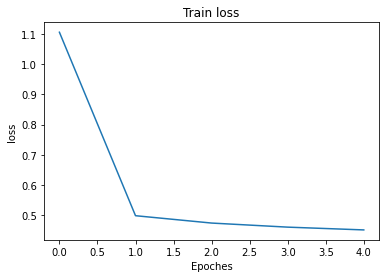

In [18]:
l = history.history['loss']
plt.plot([i for i in range(5)],l)
plt.xlabel("Epoches")
plt.ylabel("loss")
plt.title("Train loss")

In [33]:
for layer in model_cascade.layers[:-2]:
    layer.trainable = False
 
for layer in model_cascade.layers:
    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff12aa1e080> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff12f942710> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff12aa2fb70> False
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff12f942860> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7ff12a1edf28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff120222d30> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff12a1ed860> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff1202277b8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff1202000f0> False
<tensorflow.python.keras.layers.core.Dropout object at 0x7ff12022a860> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff120200c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at

In [34]:
patch_33_real = find_center_patch(real_X)
print(len(real_X))
print(len(real_y))
print(len(patch_33_real))
labels_real = {}
id_real = []
for i in range(len(patch_33_real)):
  id_real.append(str(i))
  labels_real[str(i)] = real_y[i]

training_generator = DataGenerator(id_real, labels_real, patch_33, real_X)
real_y = np.asarray(real_y, dtype = "uint8")

164231
164231
164231


In [35]:
history = model_cascade.fit(training_generator, batch_size=BATCH_SIZE , epochs=2)

Epoch 1/2
1283/1283 [==============================] - 173s 135ms/step - loss: 0.3566 - accuracy: 0.9402
Epoch 2/2
1283/1283 [==============================] - 172s 134ms/step - loss: 0.1554 - accuracy: 0.9735


In [19]:
#test
normalized_img_test = pre_process(test_images)
final_images_test = merge_different_modality(normalized_img_test)
print(len(final_images_test))
X_test, y_test, label_num = creat_patch([final_images_test[0]], 53, 26)
print("number of train sample: ", len(X_test))
print("number of train label: ", len(y_test))
print(X_test[0].shape)


start preprocess
..... waiting
finish preprocess
no tumor:  335
number of all samples:  3
number of each sample imags:  84
image shape here:  (176, 216, 5)
3
real number of each label:  [1534297, 1249, 148276, 3147, 21255]
number of train sample:  323927
number of train label:  323927
(53, 53, 4)


In [20]:
X_test, y_test = sklearn.utils.shuffle(X_test, y_test)
X_test_part = X_test[:100000]
y_test_part = y_test[:100000]
print(len(X_test_part))
patch_33_test = find_center_patch(X_test_part)
print(len(patch_33_test))

100000
100000


In [21]:
X_test_part = np.asarray(X_test_part, dtype = "uint8")
patch_33_test = np.asarray(patch_33_test, dtype = "uint8")
y_test_part = np.asarray(y_test_part, dtype = "uint8")
print(len(y_test_part))
print(len(X_test_part))
print(len(patch_33_test))

100000
100000
100000


In [36]:
p = model_cascade.predict([X_test_part, patch_33_test])

In [37]:
all = [0,0,0,0,0]
pred = [0,0,0,0,0]
crr = [0,0,0,0,0]
for i,j in zip(p,y_test_part):
  all[list(j).index(1)]+=1
  pred[np.argmax(i)]+=1
  if list(j).index(1) == np.argmax(i):
    crr[np.argmax(i)]+=1
  # print(np.argmax(i), print(np.argmax(j)))
print(all)
print(pred)
print(crr)

[46272, 397, 45698, 970, 6663]
[35722, 9148, 42645, 3400, 9085]
[33726, 197, 27535, 4, 3614]


In [38]:
def dice(pred, real, classes):
  same = 0
  classes_num_p = 0
  classes_num_r = 0
  
  for p, r in zip(pred, real):
    if np.argmax(p) in classes:
      classes_num_p+=1
    if list(r).index(1) in classes:
      classes_num_r+=1
    if  np.argmax(p) == list(r).index(1) and np.argmax(p) in classes:
      same+=1

  return same/((classes_num_p + classes_num_r)/2)  

def sensitivity(pred, real, classes):
  same = 0
  classes_num_p = 0
  classes_num_r = 0
  
  for p, r in zip(pred, real):
    if np.argmax(p) in classes:
      classes_num_p+=1
    if list(r).index(1) in classes:
      classes_num_r+=1
    if  np.argmax(p) == list(r).index(1) and np.argmax(p) in classes:
      same+=1

  return same/classes_num_r  

def specificity(pred, real, classes):
  same = 0
  classes_num_p = 0
  classes_num_r = 0
  
  for p, r in zip(pred, real):
    if np.argmax(p) not in classes:
      classes_num_p+=1
    if list(r).index(1) not in classes:
      classes_num_r+=1
    if  np.argmax(p) == list(r).index(1) and np.argmax(p) not in classes:
      same+=1

  return same/classes_num_r  

In [43]:
d = dice(p, y_test_part, [4])
sen = sensitivity(p, y_test_part, [4])
spe = specificity(p, y_test_part, [4])

In [44]:
print("dice: ", d)
print("sensitivity: ", sen)
print("specificity: ", spe)


dice:  0.4589789179578359
sensitivity:  0.5423983190754915
specificity:  0.6584955591030353


(13, 13, 4, 160)


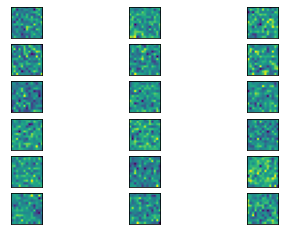

In [70]:
# retrieve weights from the second hidden layer
filters, biases = model_cascade.layers[13].get_weights()
# normalize filter values to 0-1 so we can visualize them
print(filters.shape)
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# # plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j])
		ix += 1
# show the figure
plt.show()